In [1]:
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlens.ensemble import SuperLearner
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
import seaborn as sns
from imblearn.pipeline import Pipeline
import shap
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import pickle
import seaborn as sns
sns.set(style="white")

# For reproducibility
np.random.seed(42)

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[MLENS] backend: threading


In [2]:
X_train = np.load('X_train_death_no_lab_measurement.npy')
X_test = np.load('X_test_death_no_lab_measurement.npy')
y_train = np.load('y_train_death_no_lab_measurement.npy')
y_test = np.load('y_test_death_no_lab_measurement.npy')

In [3]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([457910, 129515]))

In [4]:
# Get the validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# XGBoost

In [107]:
# Tune the XGBoost model using Bayesian optimisation
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for XGBoost hyperparameters
# Depth of tree
max_depth = np.linspace(1, 12, 12, endpoint=True)
max_depth = [round(x) for x in max_depth]
# maximum features
n_estimators = list(range(50, 400, 50))
# Learning rate
lr = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
# Regularisation for imbalanced data
max_delta_step = [0, 1, 3, 5, 7, 10]
# Gamma for overfitting control
min_split_loss = [0, 0.5]
# Balance weights for imbalanced classes for AUC
scale_pos_weight = [3.536]
tree_method = ['hist']

# Create the grid
param_grid = {'max_depth': max_depth,
               'n_estimators': n_estimators,
               'learning_rate': lr,
              'max_delta_step': max_delta_step,
             'tree_method': tree_method,
             'min_split_loss': min_split_loss,
             'scale_pos_weight': scale_pos_weight}

In [108]:
# Define the model you are interested in
XGBOOSTmodel = XGBClassifier(use_label_encoder=False)

In [109]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(XGBOOSTmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:24:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:24:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:26:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:28:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:28:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:28:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:28:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:30:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:31:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:34:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:34:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:34:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:36:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:40:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:42:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False, gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=None, min_...
                                      use_label_encoder=False,
                                      validate_parameters=None,
                                      verbosity=None),
              refit=False, scoring='roc_auc',
              search_spaces={'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5, 0.7],
   

In [110]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_delta_step', 1), ('max_depth', 4), ('min_split_loss', 0.4532079403282646), ('n_estimators', 350), ('scale_pos_weight', 3.536), ('tree_method', 'hist')])
Best AUROC: 0.7435341485082314


Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_delta_step', 1), ('max_depth', 4), ('min_split_loss', 0.4532079403282646), ('n_estimators', 350), ('scale_pos_weight', 3.536), ('tree_method', 'hist')])

In [5]:
# Test the model on standalone set
XGBOOSTmodel = XGBClassifier(max_depth = 4, n_estimators = 350,learning_rate = 0.1, max_delta_step = 1, min_split_loss = 0.5, scale_pos_weight = 3.536, use_label_encoder=False)

In [6]:
XGBOOSTmodel.fit(X_train, np.ravel(y_train))

[09:11:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=1,
              max_depth=4, min_child_weight=1, min_split_loss=0.5, missing=nan,
              monotone_constraints='()', n_estimators=350, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.536, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [113]:
# Test results without undersampling or thresholding
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, XGBOOSTmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, XGBOOSTmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, XGBOOSTmodel.predict(X_test)))
print('#################################################')

Results:
AUROC is: 0.7418881173043729
Accuracy is: 0.6527370162811442
Average Precision is: 0.4125962628137091
Weighted F1 is: 0.6821496273245301
Sensitivity is: 0.7266746965625869
#################################################


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.


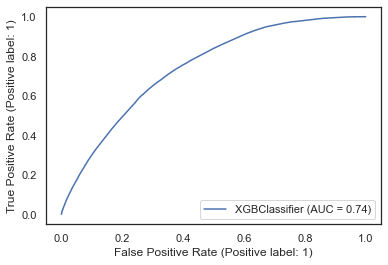

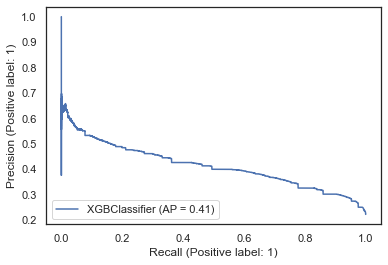

In [114]:
# Make metric plots
metrics.plot_roc_curve(XGBOOSTmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(XGBOOSTmodel, X_test, y_test) 
plt.show()

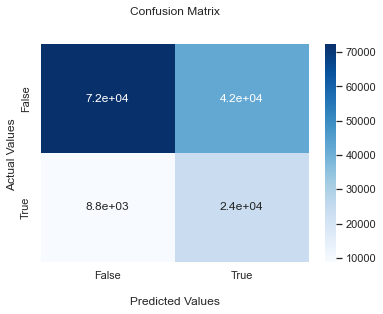

In [115]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, XGBOOSTmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
# Feature importance
explainer = shap.TreeExplainer(XGBOOSTmodel)
shap_values = explainer.shap_values(X_test)

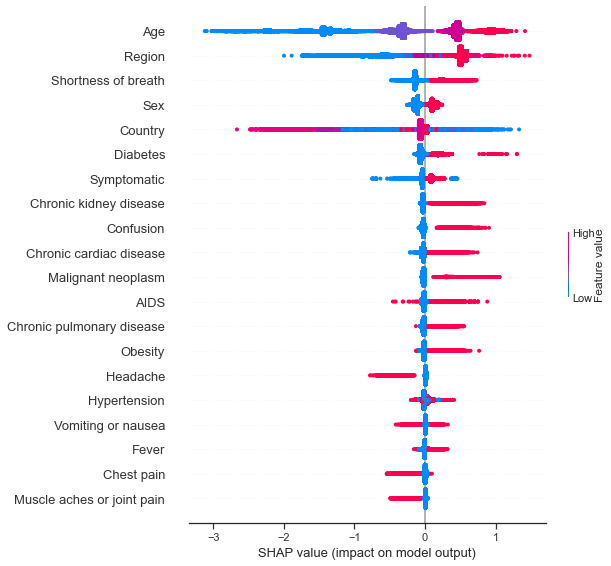

In [17]:
features = ['Age', 'Sex', 'Country', 'Region', 'AIDS', 'Asthma',
       'Chronic cardiac disease',
       'Chronic haematological disease',
       'Chronic kidney disease',
       'Chronic neurological disorder',
       'Chronic pulmonary disease', 'Dementia',
       'Diabetes', 'Hypertension', 'Immunosupression', 'Liver disease',
       'Malignant neoplasm', 'Malnutrition',
       'Obesity', 'Rheumatologic disorder',
       'Smoking', 'Tuberculosis', 'Symptomatic',
       'Abdominal pain', 'Confusion',
       'Bleeding', 'Chest pain', 'Conjunctivitis',
       'Cough', 'Diarrhoea', 'Ear pain',
       'Fatigue malaise', 'Headache',
       'Fever', 'Lost or altered sense of smell',
       'Lost or altered sense of taste', 'Lymphadenopathy',
       'Muscle aches or joint pain', 'Runny nose',
       'Seizures', 'Severe dehydration',
       'Shortness of breath', 'Skin rash',
       'Sore throat', 'Vomiting or nausea', 'Wheezing', 'PE']
f = plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=features, max_display=20)
f.savefig("Death_Shap.png", bbox_inches='tight', dpi=600)

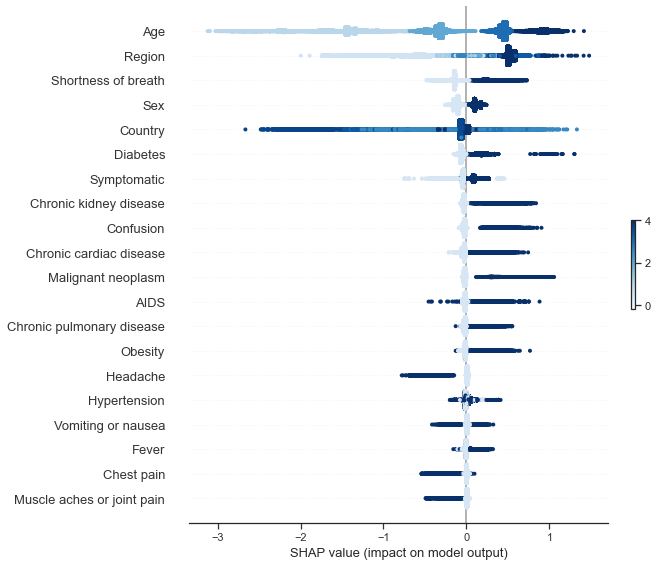

In [45]:
# Define colormap
my_cmap = plt.get_cmap('Blues')

f = plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=features, show=False, color_bar=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            fcc.set_clim(vmin=-0.2)
plt.colorbar(fraction=0.01)
            
f.savefig("Death_Shap.png", bbox_inches='tight', dpi=600)

<Figure size 432x288 with 0 Axes>

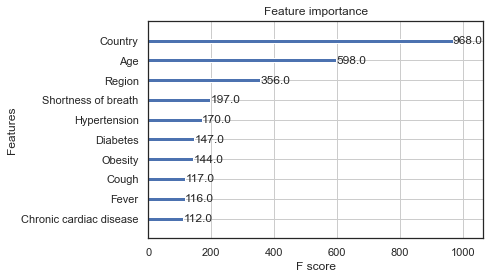

In [118]:
XGBOOSTmodel.get_booster().feature_names = features
f = plt.figure()
plot_importance(XGBOOSTmodel.get_booster(), max_num_features=10)
plt.savefig('Death_FI.png', dpi=600, bbox_inches='tight')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


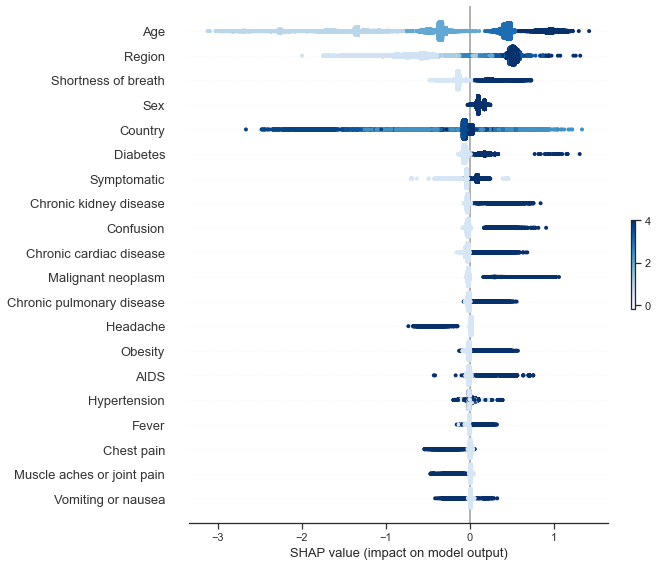

In [8]:
# Feature importance for Men
explainer = shap.TreeExplainer(XGBOOSTmodel)
shap_values = explainer.shap_values(X_test_men)

features = ['Age', 'Sex', 'Country', 'Region', 'AIDS', 'Asthma',
       'Chronic cardiac disease',
       'Chronic haematological disease',
       'Chronic kidney disease',
       'Chronic neurological disorder',
       'Chronic pulmonary disease', 'Dementia',
       'Diabetes', 'Hypertension', 'Immunosupression', 'Liver disease',
       'Malignant neoplasm', 'Malnutrition',
       'Obesity', 'Rheumatologic disorder',
       'Smoking', 'Tuberculosis', 'Symptomatic',
       'Abdominal pain', 'Confusion',
       'Bleeding', 'Chest pain', 'Conjunctivitis',
       'Cough', 'Diarrhoea', 'Ear pain',
       'Fatigue malaise', 'Headache',
       'Fever', 'Lost or altered sense of smell',
       'Lost or altered sense of taste', 'Lymphadenopathy',
       'Muscle aches or joint pain', 'Runny nose',
       'Seizures', 'Severe dehydration',
       'Shortness of breath', 'Skin rash',
       'Sore throat', 'Vomiting or nausea', 'Wheezing', 'PE']

# Define colormap
my_cmap = plt.get_cmap('Blues')

f = plt.figure()
shap.summary_plot(shap_values, X_test_men, feature_names=features, show=False, color_bar=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            fcc.set_clim(vmin=-0.2)
plt.colorbar(fraction=0.01)
            
f.savefig("Death_Shap_Men.png", bbox_inches='tight', dpi=600)

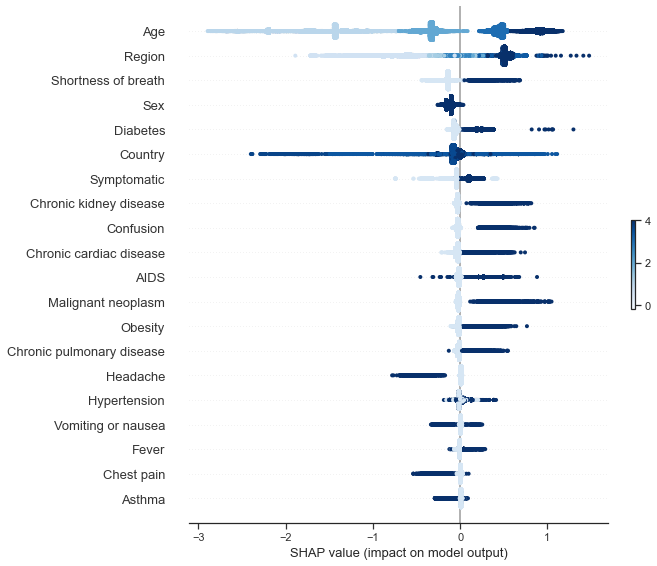

In [9]:
# Feature importance for Women
explainer = shap.TreeExplainer(XGBOOSTmodel)
shap_values = explainer.shap_values(X_test_women)

features = ['Age', 'Sex', 'Country', 'Region', 'AIDS', 'Asthma',
       'Chronic cardiac disease',
       'Chronic haematological disease',
       'Chronic kidney disease',
       'Chronic neurological disorder',
       'Chronic pulmonary disease', 'Dementia',
       'Diabetes', 'Hypertension', 'Immunosupression', 'Liver disease',
       'Malignant neoplasm', 'Malnutrition',
       'Obesity', 'Rheumatologic disorder',
       'Smoking', 'Tuberculosis', 'Symptomatic',
       'Abdominal pain', 'Confusion',
       'Bleeding', 'Chest pain', 'Conjunctivitis',
       'Cough', 'Diarrhoea', 'Ear pain',
       'Fatigue malaise', 'Headache',
       'Fever', 'Lost or altered sense of smell',
       'Lost or altered sense of taste', 'Lymphadenopathy',
       'Muscle aches or joint pain', 'Runny nose',
       'Seizures', 'Severe dehydration',
       'Shortness of breath', 'Skin rash',
       'Sore throat', 'Vomiting or nausea', 'Wheezing', 'PE']

# Define colormap
my_cmap = plt.get_cmap('Blues')

f = plt.figure()
shap.summary_plot(shap_values, X_test_women, feature_names=features, show=False, color_bar=False)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            fcc.set_clim(vmin=-0.2)
plt.colorbar(fraction=0.01)
            
f.savefig("Death_Shap_Women.png", bbox_inches='tight', dpi=600)

In [119]:
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = XGBOOSTmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.510, AUROC-Score=0.68422


In [120]:
y_pred = (XGBOOSTmodel.predict_proba(X_test)[:,1] >= 0.510).astype(int) # set threshold as 0.3

print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred))
print('#################################################')

Results:
AUROC is: 0.6790349617154572
Accuracy is: 0.6612078416418693
Average Precision is: 0.3218016987664569
Weighted F1 is: 0.6895263993173458
Sensitivity is: 0.7109237468729732
#################################################


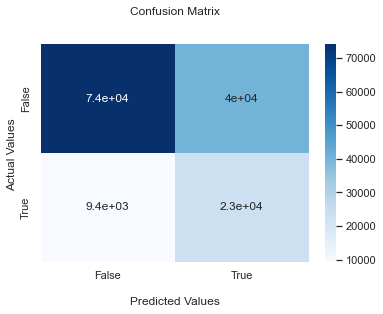

In [121]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [7]:
# Evaluate only on specific subpopulations
y_test_men = y_test[np.where(X_test[:,1] == 1)[0]]
X_test_men = X_test[np.where(X_test[:,1] == 1)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (Men)')
print('AUROC is:', metrics.roc_auc_score(y_test_men, XGBOOSTmodel.predict_proba(X_test_men)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_men, XGBOOSTmodel.predict(X_test_men)))
print('Average Precision is:', metrics.average_precision_score(y_test_men, XGBOOSTmodel.predict_proba(X_test_men)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_men, XGBOOSTmodel.predict(X_test_men), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_men, XGBOOSTmodel.predict(X_test_men)))
print('#################################################')
y_test_women = y_test[np.where(X_test[:,1] == 0)[0]]
X_test_women = X_test[np.where(X_test[:,1] == 0)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (Women)')
print('AUROC is:', metrics.roc_auc_score(y_test_women, XGBOOSTmodel.predict_proba(X_test_women)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_women, XGBOOSTmodel.predict(X_test_women)))
print('Average Precision is:', metrics.average_precision_score(y_test_women, XGBOOSTmodel.predict_proba(X_test_women)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_women, XGBOOSTmodel.predict(X_test_women), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_women, XGBOOSTmodel.predict(X_test_women)))
print('#################################################')
y_test_20 = y_test[np.where(X_test[:,0] == 0)[0]]
X_test_20 = X_test[np.where(X_test[:,0] == 0)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (0-20)')
print('AUROC is:', metrics.roc_auc_score(y_test_20, XGBOOSTmodel.predict_proba(X_test_20)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_20, XGBOOSTmodel.predict(X_test_20)))
print('Average Precision is:', metrics.average_precision_score(y_test_20, XGBOOSTmodel.predict_proba(X_test_20)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_20, XGBOOSTmodel.predict(X_test_20), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_20, XGBOOSTmodel.predict(X_test_20)))
print('#################################################')
y_test_40 = y_test[np.where(X_test[:,0] == 1)[0]]
X_test_40 = X_test[np.where(X_test[:,0] == 1)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (20-40)')
print('AUROC is:', metrics.roc_auc_score(y_test_40, XGBOOSTmodel.predict_proba(X_test_40)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_40, XGBOOSTmodel.predict(X_test_40)))
print('Average Precision is:', metrics.average_precision_score(y_test_40, XGBOOSTmodel.predict_proba(X_test_40)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_40, XGBOOSTmodel.predict(X_test_40), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_40, XGBOOSTmodel.predict(X_test_40)))
print('#################################################')
y_test_60 = y_test[np.where(X_test[:,0] == 2)[0]]
X_test_60 = X_test[np.where(X_test[:,0] == 2)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (40-60)')
print('AUROC is:', metrics.roc_auc_score(y_test_60, XGBOOSTmodel.predict_proba(X_test_60)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_60, XGBOOSTmodel.predict(X_test_60)))
print('Average Precision is:', metrics.average_precision_score(y_test_60, XGBOOSTmodel.predict_proba(X_test_60)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_60, XGBOOSTmodel.predict(X_test_60), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_60, XGBOOSTmodel.predict(X_test_60)))
print('#################################################')
y_test_80 = y_test[np.where(X_test[:,0] == 3)[0]]
X_test_80 = X_test[np.where(X_test[:,0] == 3)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (60-80)')
print('AUROC is:', metrics.roc_auc_score(y_test_80, XGBOOSTmodel.predict_proba(X_test_80)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_80, XGBOOSTmodel.predict(X_test_80)))
print('Average Precision is:', metrics.average_precision_score(y_test_80, XGBOOSTmodel.predict_proba(X_test_80)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_80, XGBOOSTmodel.predict(X_test_80), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_80, XGBOOSTmodel.predict(X_test_80)))
print('#################################################')
y_test_120 = y_test[np.where(X_test[:,0] == 4)[0]]
X_test_120 = X_test[np.where(X_test[:,0] == 4)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (>80)')
print('AUROC is:', metrics.roc_auc_score(y_test_120, XGBOOSTmodel.predict_proba(X_test_120)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_120, XGBOOSTmodel.predict(X_test_120)))
print('Average Precision is:', metrics.average_precision_score(y_test_120, XGBOOSTmodel.predict_proba(X_test_120)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_120, XGBOOSTmodel.predict(X_test_120), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_120, XGBOOSTmodel.predict(X_test_120)))
print('#################################################')

Results for UK+Spain (Men)
AUROC is: 0.7395732867304788
Accuracy is: 0.6419074071527768
Average Precision is: 0.43753400404129295
Weighted F1 is: 0.6680010027638303
Sensitivity is: 0.7462053954980239
#################################################
Results for UK+Spain (Women)
AUROC is: 0.7402352738220349
Accuracy is: 0.6633616619452314
Average Precision is: 0.37256214356020634
Weighted F1 is: 0.6958734484906969
Sensitivity is: 0.7038203753351207
#################################################
Results for UK+Spain (0-20)
AUROC is: 0.7097285912760576
Accuracy is: 0.9729416871653885
Average Precision is: 0.13646209820133262
Weighted F1 is: 0.963398850613484
Sensitivity is: 0.0851063829787234
#################################################
Results for UK+Spain (20-40)
AUROC is: 0.702355339170995
Accuracy is: 0.9303936005094122
Average Precision is: 0.14610766441549344
Weighted F1 is: 0.905243099666073
Sensitivity is: 0.041742286751361164
##############################################

# Random Forest

In [122]:
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for RF hyperparameters
# Number of trees in random forest
n_estimators = [10, 25, 50, 100, 150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# To account for class imbalance
class_weight=['balanced_subsample']

# Create the grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
             'class_weight': class_weight}

In [123]:
# Define the model you are interested in
RFmodel = RandomForestClassifier()

In [124]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(RFmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=RandomForestClassifier(), refit=False,
              scoring='roc_auc',
              search_spaces={'bootstrap': [True, False],
                             'class_weight': ['balanced_subsample'],
                             'max_depth': [10, 50, None],
                             'max_features': ['auto', 'sqrt'],
                             'min_samples_leaf': [2, 4, 10],
                             'min_samples_split': [5, 10],
                             'n_estimators': [10, 25, 50, 100, 150]},
              verbose=1)

In [126]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('bootstrap', False), ('class_weight', 'balanced_subsample'), ('max_depth', None), ('max_features', 'auto'), ('min_samples_leaf', 10), ('min_samples_split', 10), ('n_estimators', 150)])
Best AUROC: 0.7409992615503957


Best parameter combo: OrderedDict([('bootstrap', False), ('class_weight', 'balanced_subsample'), ('max_depth', None), ('max_features', 'auto'), ('min_samples_leaf', 10), ('min_samples_split', 10), ('n_estimators', 150)])


In [127]:
# Test the model on standalone set
RFmodel = RandomForestClassifier(n_estimators = 150, max_features = 'auto', max_depth = None, min_samples_split = 10, min_samples_leaf = 10, class_weight = 'balanced_subsample', bootstrap = False)

In [128]:
RFmodel.fit(X_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=150)

In [129]:
# Test results without undersampling or thresholding
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, RFmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, RFmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, RFmodel.predict(X_test)))
print('#################################################')

Results:
AUROC is: 0.7389808971485003
Accuracy is: 0.6546300142315313
Average Precision is: 0.40832652742021014
Weighted F1 is: 0.6837285026874793
Sensitivity is: 0.7149386948330708
#################################################


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.


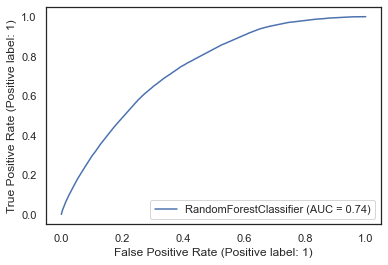

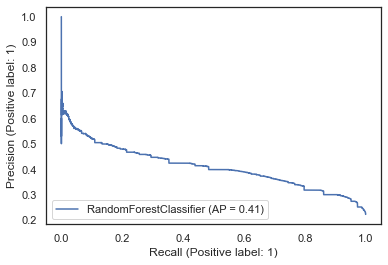

In [130]:
# Make metric plots
metrics.plot_roc_curve(RFmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(RFmodel, X_test, y_test) 
plt.show()

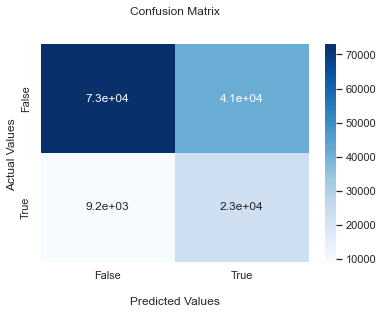

In [131]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, RFmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [132]:
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = RFmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.511, AUROC-Score=0.69668


In [133]:
y_pred = (RFmodel.predict_proba(X_test)[:,1] >= 0.511).astype(int) # set threshold as 0.3

print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred))
print('#################################################')

Results:
AUROC is: 0.675953228532242
Accuracy is: 0.6593556997623539
Average Precision is: 0.319427139046328
Weighted F1 is: 0.6878145295984256
Sensitivity is: 0.705642546094691
#################################################


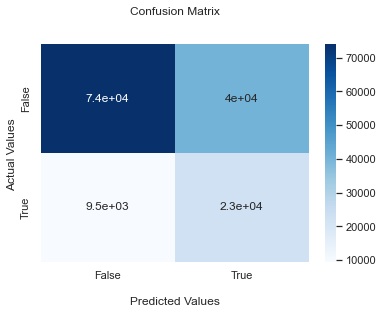

In [134]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Logistic Regression

In [135]:
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for ElasticNet hyperparameters
# Regularisation constant
classifier__C = [1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# Which norm to use for regularisation
classifier__penalty = ['l1', 'l2']

# Create the grid
param_grid = {'C': classifier__C,
               'penalty': classifier__penalty}

In [136]:
# Define the model you are interested in
LOGmodel = LogisticRegression(solver='liblinear', class_weight = 'balanced')

In [137]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(LOGmodel, param_grid, n_iter=20, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=LogisticRegression(class_weight='balanced',
                                           solver='liblinear'),
              n_iter=20, refit=False, scoring='roc_auc',
              search_spaces={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000],
                             'penalty': ['l1', 'l2']},
              verbose=1)

In [139]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('C', 0.01), ('penalty', 'l1')])
Best AUROC: 0.7317468196690383


Best parameter combo: OrderedDict([('C', 0.01), ('penalty', 'l1')])


In [8]:
# Test the model on standalone set
LOGmodel = LogisticRegression(C=0.01, penalty='l1', solver='liblinear', class_weight = 'balanced')

In [9]:
LOGmodel.fit(X_train, np.ravel(y_train))

LogisticRegression(C=0.01, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [142]:
# Test results without undersampling or thresholding
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, LOGmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, LOGmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, LOGmodel.predict(X_test)))

Results:
AUROC is: 0.729108556190107
Accuracy is: 0.661643639731167
Average Precision is: 0.3938792905792734
Weighted F1 is: 0.6894966443057982
Sensitivity is: 0.683961827110164


Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.


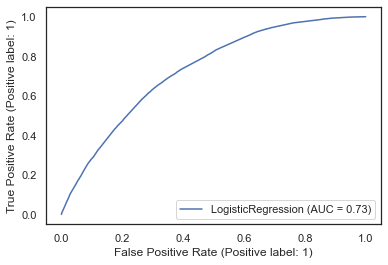

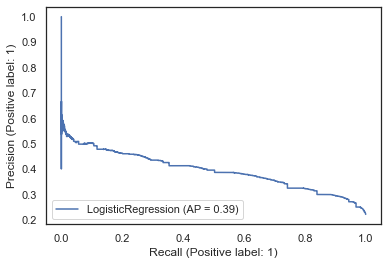

In [143]:
# Make metric plots
metrics.plot_roc_curve(LOGmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(LOGmodel, X_test, y_test) 
plt.show()

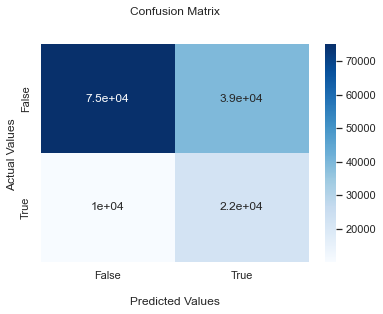

In [144]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, LOGmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [10]:
# Evaluate only on specific subpopulations
y_test_men = y_test[np.where(X_test[:,1] == 1)[0]]
X_test_men = X_test[np.where(X_test[:,1] == 1)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (Men)')
print('AUROC is:', metrics.roc_auc_score(y_test_men, LOGmodel.predict_proba(X_test_men)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_men, LOGmodel.predict(X_test_men)))
print('Average Precision is:', metrics.average_precision_score(y_test_men, LOGmodel.predict_proba(X_test_men)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_men, LOGmodel.predict(X_test_men), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_men, LOGmodel.predict(X_test_men)))
print('#################################################')
y_test_women = y_test[np.where(X_test[:,1] == 0)[0]]
X_test_women = X_test[np.where(X_test[:,1] == 0)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (Women)')
print('AUROC is:', metrics.roc_auc_score(y_test_women, LOGmodel.predict_proba(X_test_women)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_women, LOGmodel.predict(X_test_women)))
print('Average Precision is:', metrics.average_precision_score(y_test_women, LOGmodel.predict_proba(X_test_women)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_women, LOGmodel.predict(X_test_women), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_women, LOGmodel.predict(X_test_women)))
print('#################################################')
y_test_20 = y_test[np.where(X_test[:,0] == 0)[0]]
X_test_20 = X_test[np.where(X_test[:,0] == 0)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (0-20)')
print('AUROC is:', metrics.roc_auc_score(y_test_20, LOGmodel.predict_proba(X_test_20)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_20, LOGmodel.predict(X_test_20)))
print('Average Precision is:', metrics.average_precision_score(y_test_20, LOGmodel.predict_proba(X_test_20)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_20, LOGmodel.predict(X_test_20), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_20, LOGmodel.predict(X_test_20)))
print('#################################################')
y_test_40 = y_test[np.where(X_test[:,0] == 1)[0]]
X_test_40 = X_test[np.where(X_test[:,0] == 1)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (20-40)')
print('AUROC is:', metrics.roc_auc_score(y_test_40, LOGmodel.predict_proba(X_test_40)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_40, LOGmodel.predict(X_test_40)))
print('Average Precision is:', metrics.average_precision_score(y_test_40, LOGmodel.predict_proba(X_test_40)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_40, LOGmodel.predict(X_test_40), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_40, LOGmodel.predict(X_test_40)))
print('#################################################')
y_test_60 = y_test[np.where(X_test[:,0] == 2)[0]]
X_test_60 = X_test[np.where(X_test[:,0] == 2)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (40-60)')
print('AUROC is:', metrics.roc_auc_score(y_test_60, LOGmodel.predict_proba(X_test_60)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_60, LOGmodel.predict(X_test_60)))
print('Average Precision is:', metrics.average_precision_score(y_test_60, LOGmodel.predict_proba(X_test_60)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_60, LOGmodel.predict(X_test_60), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_60, LOGmodel.predict(X_test_60)))
print('#################################################')
y_test_80 = y_test[np.where(X_test[:,0] == 3)[0]]
X_test_80 = X_test[np.where(X_test[:,0] == 3)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (60-80)')
print('AUROC is:', metrics.roc_auc_score(y_test_80, LOGmodel.predict_proba(X_test_80)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_80, LOGmodel.predict(X_test_80)))
print('Average Precision is:', metrics.average_precision_score(y_test_80, LOGmodel.predict_proba(X_test_80)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_80, LOGmodel.predict(X_test_80), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_80, LOGmodel.predict(X_test_80)))
print('#################################################')
y_test_120 = y_test[np.where(X_test[:,0] == 4)[0]]
X_test_120 = X_test[np.where(X_test[:,0] == 4)[0], :]
# Test results without undersampling or thresholding
print('Results for UK+Spain (>80)')
print('AUROC is:', metrics.roc_auc_score(y_test_120, LOGmodel.predict_proba(X_test_120)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test_120, LOGmodel.predict(X_test_120)))
print('Average Precision is:', metrics.average_precision_score(y_test_120, LOGmodel.predict_proba(X_test_120)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test_120, LOGmodel.predict(X_test_120), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test_120, LOGmodel.predict(X_test_120)))
print('#################################################')

Results for UK+Spain (Men)
AUROC is: 0.7244819320549771
Accuracy is: 0.6443961664856244
Average Precision is: 0.41767390849602803
Weighted F1 is: 0.6701342850378779
Sensitivity is: 0.7120682742425111
#################################################
Results for UK+Spain (Women)
AUROC is: 0.7292831191564718
Accuracy is: 0.6785646836638338
Average Precision is: 0.35879958478975715
Weighted F1 is: 0.7078774860943072
Sensitivity is: 0.6510723860589812
#################################################
Results for UK+Spain (0-20)
AUROC is: 0.6084238451046107
Accuracy is: 0.9727969903053104
Average Precision is: 0.04284886379932046
Weighted F1 is: 0.9593830373804608
Sensitivity is: 0.0
#################################################
Results for UK+Spain (20-40)
AUROC is: 0.6782698815298656
Accuracy is: 0.934094798424006
Average Precision is: 0.12008739471473083
Weighted F1 is: 0.9024584437748797
Sensitivity is: 0.0006049606775559589
#################################################
Results 

In [146]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = LOGmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.464, AUROC-Score=0.67357


In [147]:
# Set the optimal threshold for class imbalance purposes
y_pred = (LOGmodel.predict_proba(X_test)[:,1] >= 0.464).astype(int)
# Test results with thresholding and no undersampling
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred))
print('#################################################')

Results:
AUROC is: 0.6702013185177654
Accuracy is: 0.6374908925008682
Average Precision is: 0.312487643020169
Weighted F1 is: 0.6684191465912181
Sensitivity is: 0.7287130547577133
#################################################


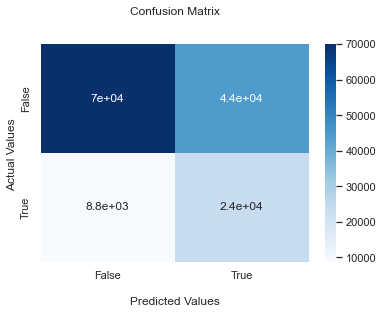

In [148]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

# EasyEnsemble

In [149]:
# In this case we are tuning for EasyEnsemble hyperparameters
# maximum number of trees
n_estimators = list(range(10, 100, 10))

# Create the grid
param_grid = {'n_estimators': n_estimators}

In [150]:
# Define the model you are interested in
EEModel = EasyEnsembleClassifier(random_state=42)

In [151]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(EEModel, param_grid, cv=cv, n_iter=10, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=EasyEnsembleClassifier(random_state=42), n_iter=10,
              refit=False, scoring='roc_auc',
              search_spaces={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80,
                                              90]},
              verbose=1)

In [152]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('n_estimators', 20)])
Best AUROC: 0.7331888527164472


In [153]:
# Test the model on standalone set
EEModel = EasyEnsembleClassifier(n_estimators=20, random_state=42)

In [154]:
EEModel.fit(X_train, np.ravel(y_train))

EasyEnsembleClassifier(n_estimators=20, random_state=42)

In [155]:
# Test results without undersampling or thresholding
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, EEModel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, EEModel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, EEModel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, EEModel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, EEModel.predict(X_test)))

Results:
AUROC is: 0.7306223947769939
Accuracy is: 0.6576261260954533
Average Precision is: 0.39414128326461284
Weighted F1 is: 0.6861240896006829
Sensitivity is: 0.6942771549461071


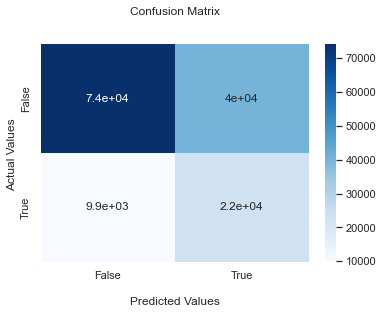

In [156]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, EEModel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [157]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = EEModel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.499, AUROC-Score=0.67499


In [158]:
# Set the optimal threshold for class imbalance purposes
y_pred = (EEModel.predict_proba(X_test)[:,1] >= 0.499).astype(int)

In [159]:
# Test results with thresholding and undersampling
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred))

Results:
AUROC is: 0.6711084330061227
Accuracy is: 0.627889715846027
Average Precision is: 0.31187169677124793
Weighted F1 is: 0.6596565221920896
Sensitivity is: 0.7484171839772692


# EasyEnsemble with XGBoost


In [160]:
# In this case we are tuning for EasyEnsemble hyperparameters
# maximum number of trees
n_estimators = list(range(10, 100, 10))

# Create the grid
param_grid = {'n_estimators': n_estimators}

In [161]:
# Define the model you are interested in
EEModel = EasyEnsembleClassifier(random_state=42, base_estimator=XGBClassifier(use_label_encoder=False))

In [162]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(EEModel, param_grid, cv=cv, n_iter=10, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[08:35:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:35:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:35:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

[08:39:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:39:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:39:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:39:50] WARNING: /Users/runner/miniforge3/cond

[08:43:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:43:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:43:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:07] WARNING: /Users/runner/miniforge3/cond

[08:47:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:48:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:48:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:48:34] WARNING: /Users/runner/miniforge3/cond

[08:52:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:52:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:52:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:52:57] WARNING: /Users/runner/miniforge3/cond

[08:56:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:56:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:18] WARNING: /Users/runner/miniforge3/cond

[09:01:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:01:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:01:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:01:42] WARNING: /Users/runner/miniforge3/cond

[09:05:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:06:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:06:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:06:40] WARNING: /Users/runner/miniforge3/cond

[09:11:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:11:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:11:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:11:46] WARNING: /Users/runner/miniforge3/cond

[09:16:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:17:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:17:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:17:30] WARNING: /Users/runner/miniforge3/cond

[09:22:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:22:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:22:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:23:05] WARNING: /Users/runner/miniforge3/cond

[09:27:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:27:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:27:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:28:09] WARNING: /Users/runner/miniforge3/cond

[09:32:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:32:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:32:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:32:56] WARNING: /Users/runner/miniforge3/cond

[09:37:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:37:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:37:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:37:55] WARNING: /Users/runner/miniforge3/cond

[09:42:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:42:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:42:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:42:47] WARNING: /Users/runner/miniforge3/cond

[09:47:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:47:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:47:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:48:01] WARNING: /Users/runner/miniforge3/cond

[09:52:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:52:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:53:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:53:12] WARNING: /Users/runner/miniforge3/cond

[09:57:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:57:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:58:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:58:11] WARNING: /Users/runner/miniforge3/cond

[10:02:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:02:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:02:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:03:04] WARNING: /Users/runner/miniforge3/cond

[10:07:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:07:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:08:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:08:16] WARNING: /Users/runner/miniforge3/cond

[10:13:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:13:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:13:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:13:43] WARNING: /Users/runner/miniforge3/cond

[10:18:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:51] WARNING: /Users/runner/miniforge3/cond

[10:23:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:23:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:23:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:23:59] WARNING: /Users/runner/miniforge3/cond

[10:28:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:26] WARNING: /Users/runner/miniforge3/cond

[10:34:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:34:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:34:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:34:46] WARNING: /Users/runner/miniforge3/cond

[10:39:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:39:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:39:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:40:11] WARNING: /Users/runner/miniforge3/cond

[10:45:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:46] WARNING: /Users/runner/miniforge3/cond

[10:50:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:50:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:16] WARNING: /Users/runner/miniforge3/cond

[10:56:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:43] WARNING: /Users/runner/miniforge3/cond

[11:01:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:01:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:02:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:02:12] WARNING: /Users/runner/miniforge3/cond

[11:07:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:07:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:07:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:08:04] WARNING: /Users/runner/miniforge3/cond

[11:12:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:13:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:13:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:13:36] WARNING: /Users/runner/miniforge3/cond

[11:18:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:19:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:19:15] WARNING: /Users/runner/miniforge3/cond

[11:24:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:24:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:25:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:25:15] WARNING: /Users/runner/miniforge3/cond

[11:30:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:30:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:30:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:30:49] WARNING: /Users/runner/miniforge3/cond

[11:35:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:38] WARNING: /Users/runner/miniforge3/cond

[11:42:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:44] WARNING: /Users/runner/miniforge3/cond

[11:48:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:58] WARNING: /Users/runner/miniforge3/cond

[11:54:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:58] WARNING: /Users/runner/miniforge3/cond

[11:59:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:00:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:00:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:00:30] WARNING: /Users/runner/miniforge3/cond

[12:05:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:05:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:05:55] WARNING: /Users/runner/miniforge3/cond

[12:10:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:10:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:10:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:11:10] WARNING: /Users/runner/miniforge3/cond

[12:15:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:19] WARNING: /Users/runner/miniforge3/cond

[12:20:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:36] WARNING: /Users/runner/miniforge3/cond

[12:26:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:44] WARNING: /Users/runner/miniforge3/cond

[12:31:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:31:53] WARNING: /Users/runner/miniforge3/cond

[12:36:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:36:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:36:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:36:58] WARNING: /Users/runner/miniforge3/cond

[12:41:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:10] WARNING: /Users/runner/miniforge3/cond

[12:46:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:47:15] WARNING: /Users/runner/miniforge3/cond

[12:51:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:21] WARNING: /Users/runner/miniforge3/cond

[12:56:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:32] WARNING: /Users/runner/miniforge3/cond

[13:02:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:38] WARNING: /Users/runner/miniforge3/cond

[13:07:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:42] WARNING: /Users/runner/miniforge3/cond

[13:12:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:12:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:12:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:12:55] WARNING: /Users/runner/miniforge3/cond

[13:17:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:17:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:17:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:18:02] WARNING: /Users/runner/miniforge3/cond

[13:22:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:22:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:23:16] WARNING: /Users/runner/miniforge3/cond

[13:27:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:22] WARNING: /Users/runner/miniforge3/cond

[13:32:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:33:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:33:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:33:28] WARNING: /Users/runner/miniforge3/cond

[13:38:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:39] WARNING: /Users/runner/miniforge3/cond

[13:43:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:41] WARNING: /Users/runner/miniforge3/cond

[13:48:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:48:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:48:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:48:41] WARNING: /Users/runner/miniforge3/cond

[13:53:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:48] WARNING: /Users/runner/miniforge3/cond

[13:58:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:58:55] WARNING: /Users/runner/miniforge3/cond

[14:03:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:03:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:20] WARNING: /Users/runner/miniforge3/cond

[14:09:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:53] WARNING: /Users/runner/miniforge3/cond

[14:15:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:15] WARNING: /Users/runner/miniforge3/cond

[14:23:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:42] WARNING: /Users/runner/miniforge3/cond

[14:28:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:29:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:29:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:29:38] WARNING: /Users/runner/miniforge3/cond

[14:34:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:35:11] WARNING: /Users/runner/miniforge3/cond

[14:40:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:40:55] WARNING: /Users/runner/miniforge3/cond

[14:45:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:37] WARNING: /Users/runner/miniforge3/cond

[14:51:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:01] WARNING: /Users/runner/miniforge3/cond

[14:57:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:57:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:57:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:57:54] WARNING: /Users/runner/miniforge3/cond

[15:02:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:02:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:02:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:09] WARNING: /Users/runner/miniforge3/cond

[15:07:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:07:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:07:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:09] WARNING: /Users/runner/miniforge3/cond

[15:12:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:12:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:11] WARNING: /Users/runner/miniforge3/cond

[15:17:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:12] WARNING: /Users/runner/miniforge3/cond

[15:22:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:22:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:22:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:23:07] WARNING: /Users/runner/miniforge3/cond

[15:27:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:27:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:28:07] WARNING: /Users/runner/miniforge3/cond

[15:32:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:32:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:32:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:33:07] WARNING: /Users/runner/miniforge3/cond

[15:37:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:01] WARNING: /Users/runner/miniforge3/cond

[15:42:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:06] WARNING: /Users/runner/miniforge3/cond

[15:47:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:59] WARNING: /Users/runner/miniforge3/cond

[15:52:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:52:58] WARNING: /Users/runner/miniforge3/cond

[15:57:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:57:53] WARNING: /Users/runner/miniforge3/cond

[16:02:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:02:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:02:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:03] WARNING: /Users/runner/miniforge3/cond

[16:07:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:10] WARNING: /Users/runner/miniforge3/cond

[16:13:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:53] WARNING: /Users/runner/miniforge3/cond

[16:18:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:57] WARNING: /Users/runner/miniforge3/cond

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=EasyEnsembleClassifier(base_estimator=XGBClassifier(base_score=None,
                                                                            booster=None,
                                                                            colsample_bylevel=None,
                                                                            colsample_bynode=None,
                                                                            colsample_bytree=None,
                                                                            enable_categorical=False,
                                                                            gamma=None,
                                                                            gpu_id=None,
                                                                            importance_type=None,
                                                                 

In [163]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score 
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('n_estimators', 50)])
Best AUROC: 0.7441672708690955


In [164]:
# Test the model on standalone set
EEModel = EasyEnsembleClassifier(n_estimators=50, random_state=42, base_estimator=XGBClassifier(use_label_encoder=False))

In [165]:
EEModel.fit(X_train, np.ravel(y_train))

[17:20:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:36] WARNING: /Users/runner/miniforge3/cond

[17:25:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:06] WARNING: /Users/runner/miniforge3/cond

EasyEnsembleClassifier(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    enable_categorical=False,
                                                    gamma=None, gpu_id=None,
                                                    importance_type=None,
                                                    interaction_constraints=None,
                                                    learning_rate=None,
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    min_child_weight=None,
                                        

In [166]:
# Test results without undersampling or thresholding
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, EEModel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, EEModel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, EEModel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, EEModel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, EEModel.predict(X_test)))

Results:
AUROC is: 0.7425432844427182
Accuracy is: 0.651136820172004
Average Precision is: 0.4143495680750492
Weighted F1 is: 0.6807438010896836
Sensitivity is: 0.7304116865869854


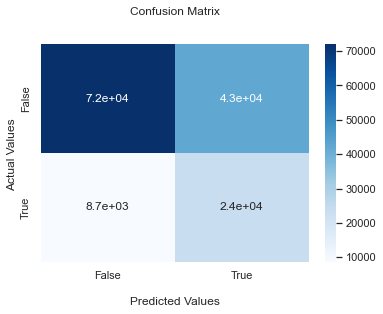

In [167]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, EEModel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [168]:
# Apply thresholding
# search thresholds for imbalanced classification

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = EEModel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.520, AUROC-Score=0.68897


In [169]:
# Set the optimal threshold for class imbalance purposes
y_pred = (EEModel.predict_proba(X_test)[:,1] >= 0.520).astype(int)

In [170]:
# Test results with thresholding and undersampling
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred))

Results:
AUROC is: 0.6788074610192432
Accuracy is: 0.6630804115568206
Average Precision is: 0.32195880844356967
Weighted F1 is: 0.6911286211839027
Sensitivity is: 0.7069396831279533


# LDA

In [207]:
# In this case we are tuning for LDA hyperparameters
# Regularisation
shrinkage = list(np.arange(0, 1, 0.01))
# Solvers
solver = ['lsqr', 'eigen']
# Create the grid
param_grid = {'shrinkage': shrinkage,
             'solver': solver}

In [208]:
LDAModel = LinearDiscriminantAnalysis()

In [209]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(LDAModel, param_grid, cv=cv, n_iter=50, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=LinearDiscriminantAnalysis(), refit=False,
              scoring='roc_auc',
              search_spaces={'shrinkage': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05,
                                           0.06, 0.07, 0.08, 0.09, 0.1, 0.11,
                                           0.12, 0.13, 0.14, 0.15, 0.16, 0.17,
                                           0.18, 0.19, 0.2, 0.21, 0.22, 0.23,
                                           0.24, 0.25, 0.26, 0.27, 0.28, 0.29, ...],
                             'solver': ['lsqr', 'eigen']},
              verbose=1)

In [211]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('shrinkage', 0.0), ('solver', 'lsqr')])
Best AUROC: 0.7313534535516583


In [212]:
# Test the model on standalone set
LDAModel = LinearDiscriminantAnalysis(shrinkage=0.0, solver = 'lsqr')

In [213]:
LDAModel.fit(X_train, np.ravel(y_train))

LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr')

In [214]:
# Test results without undersampling or thresholding
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, LDAModel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, LDAModel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, LDAModel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, LDAModel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, LDAModel.predict(X_test)))
print('#################################################')

Results:
AUROC is: 0.7286899428551697
Accuracy is: 0.7801875293653009
Average Precision is: 0.3946093734909059
Weighted F1 is: 0.7111025323995229
Sensitivity is: 0.0776738009203496
#################################################


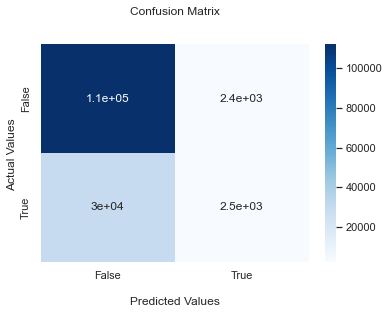

In [215]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, LDAModel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [216]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = LDAModel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.202, AUROC-Score=0.67389


In [217]:
# Set the optimal threshold for class imbalance purposes
y_pred = (LDAModel.predict_proba(X_test)[:,1] >= 0.202).astype(int)

In [218]:
# Test results with thresholding and undersampling
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred))
print('#################################################')

Results:
AUROC is: 0.6705852151007236
Accuracy is: 0.6383829167148996
Average Precision is: 0.3128527124704793
Weighted F1 is: 0.6692258697332218
Sensitivity is: 0.7281880231013929
#################################################


# Naive Bayes

In [220]:
# In this case we are tuning for Naive Bayes hyperparameters
# Smoothing parameter
alpha = [0]

# Create the grid
param_grid = {'alpha': alpha}

In [221]:
# Define the model you are interested in
NBmodel = CategoricalNB(alpha=0.0)

In [229]:
print(np.nanmean(cross_val_score(NBmodel, X_train, y_train, cv=cv, scoring='roc_auc')))

alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
alpha too small will result in numeric errors, setting alpha = 1.0e-10
Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'CategoricalNB' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packa

0.7127717942860949


In [231]:
# Test the model on standalone set
NBmodel = CategoricalNB(alpha=0.0)

In [232]:
NBmodel.fit(X_train, np.ravel(y_train))

alpha too small will result in numeric errors, setting alpha = 1.0e-10


CategoricalNB(alpha=0.0)

In [193]:
# Test results without undersampling or thresholding
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, NBmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, NBmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, NBmodel.predict_proba(X_test)[:,1]))
print('Weighted F1 is:', metrics.f1_score(y_test, NBmodel.predict(X_test), average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, NBmodel.predict(X_test)))
print('#################################################')

Results:
AUROC is: 0.7111436910830309
Accuracy is: 0.7486806893781025
Average Precision is: 0.3591096777924415
Weighted F1 is: 0.7250737541001797
Sensitivity is: 0.236696624355292
#################################################


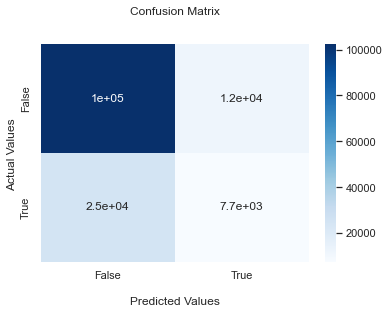

In [194]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, NBmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [195]:
# Apply thresholding
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = NBmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.200, AUROC-Score=0.67037


In [233]:
# Set the optimal threshold for class imbalance purposes
y_pred = (NBmodel.predict_proba(X_test)[:,1] >= 0.2).astype(int)

In [234]:
# Test results with thresholding and undersampling
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))
print('Weighted F1 is:', metrics.f1_score(y_test, y_pred, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, y_pred))
print('#################################################')

Results:
AUROC is: 0.6693910509905081
Accuracy is: 0.6262827103917417
Average Precision is: 0.31058027028895174
Weighted F1 is: 0.6581820604911932
Sensitivity is: 0.7465023626424534
#################################################


# SuperLearner

In [269]:
# create a list of base-models
def get_models():
    models = list()
    models.append(LogisticRegression(C=0.01, penalty='l1', solver='liblinear', class_weight = 'balanced'))
    models.append(XGBClassifier(max_depth = 4, n_estimators = 350,learning_rate = 0.1, max_delta_step = 1, min_split_loss = 0.5, use_label_encoder=False))
    models.append(LinearDiscriminantAnalysis(shrinkage=0.0, solver = 'lsqr'))
    models.append(RandomForestClassifier(n_estimators = 150, max_features = 'auto', max_depth = None, min_samples_split = 10, min_samples_leaf = 10, class_weight = 'balanced_subsample', bootstrap = False))
    return models

# create the super learner
def get_super_learner():
    ensemble = SuperLearner(scorer=metrics.roc_auc_score, folds=5, shuffle=True)
    # add base models
    models = get_models()
    ensemble.add(models)
    # add the meta model
    ensemble.add_meta(LogisticRegression(solver='lbfgs'))
    return ensemble

In [270]:
# create the super learner
ensemble = get_super_learner()
# fit the super learner
ensemble.fit(X_train, y_train)
# summarize base learners
print(ensemble.data)
# make predictions on hold out set
yhat = ensemble.predict(X_test)
# Test results without undersampling or thresholding
print('Results:')
print('AUROC is:', metrics.roc_auc_score(y_test, yhat))
print('Accuracy is:', metrics.accuracy_score(y_test, yhat))
print('Average Precision is:', metrics.average_precision_score(y_test, yhat))
print('Weighted F1 is:', metrics.f1_score(y_test, yhat, average='weighted'))
print('Sensitivity is:', metrics.recall_score(y_test, yhat))
print('#################################################')

[09:16:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:16:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:19:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:20:06] WARNING: /Users/runner/miniforge3/cond

                                       score-m  score-s    ft-m   ft-s  pt-m  pt-s
layer-1  lineardiscriminantanalysis       0.53     0.00    3.57   0.15  0.04  0.01
layer-1  logisticregression               0.67     0.00   67.66   1.82  0.06  0.02
layer-1  randomforestclassifier           0.68     0.00  296.92   8.01  6.97  0.97
layer-1  xgbclassifier                    0.53     0.00  229.96  20.79  0.21  0.06

Results:
AUROC is: 0.5193236111287572
Accuracy is: 0.7818490095807487
Average Precision is: 0.23733292350708907
Weighted F1 is: 0.7030311808859295
Sensitivity is: 0.04972358627505482
#################################################


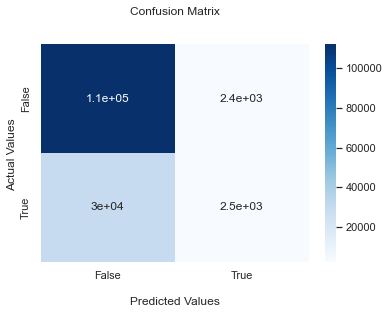

In [258]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, ensemble.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()